In [2]:
from google.colab import files
files=files.upload()

Saving Reddit_Data.csv to Reddit_Data.csv
Saving Twitter_Data.csv to Twitter_Data.csv


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
reddit_df = pd.read_csv(r"DataSets/Reddit_Data.csv")
twitter_df = pd.read_csv(r"DataSets/Twitter_Data.csv")

In [5]:
reddit_df.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [6]:
reddit_df.tail()

,clean_comment,category
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1
37248,facebook itself now working bjp’ cell,0


In [7]:
twitter_df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [8]:
twitter_df.tail()

,clean_text,category
162975,why these 456 crores paid neerav modi not reco...,-1.0
162976,dear rss terrorist payal gawar what about modi...,-1.0
162977,did you cover her interaction forum where she ...,0.0
162978,there big project came into india modi dream p...,0.0
162979,have you ever listen about like gurukul where ...,1.0


In [9]:
print(reddit_df.shape)
print(twitter_df.shape)

(37249, 2)
(162980, 2)


In [10]:
print(reddit_df.columns)
print(twitter_df.columns)

Index(['clean_comment', 'category'], dtype='object')
Index(['clean_text', 'category'], dtype='object')


In [11]:
print(reddit_df.dtypes)
print(twitter_df.dtypes)

clean_comment    object
category          int64
dtype: object
clean_text     object
category      float64
dtype: object


In [12]:
print(reddit_df.isnull().sum())
print(twitter_df.isnull().sum())

clean_comment    100
category           0
dtype: int64
clean_text    4
category      7
dtype: int64


In [13]:
reddit_df.dropna(inplace=True)
twitter_df.dropna(inplace=True)

In [14]:
print(reddit_df.isnull().sum())
print(twitter_df.isnull().sum())

clean_comment    0
category         0
dtype: int64
clean_text    0
category      0
dtype: int64


In [15]:
print(reddit_df.duplicated().sum())
print(twitter_df.duplicated().sum())

350
0


In [16]:
reddit_df.drop_duplicates(inplace=True)

In [17]:
print(reddit_df.duplicated().sum())

0


###### Merge Data

In [18]:
reddit_df["category"] = reddit_df["category"].astype(int)
twitter_df["category"] = twitter_df["category"].astype(int)

In [19]:
reddit_df = reddit_df.rename(columns={"clean_comment": "clean_text"})
twitter_df = twitter_df.rename(columns={"clean_text": "clean_text"})

In [20]:
reddit_df["source"] = "Reddit"
twitter_df["source"] = "Twitter"

In [21]:
merged_df = pd.concat([twitter_df, reddit_df], ignore_index=True)

######Text Preprocessing

In [22]:
nltk.download('stopwords', quiet=True)
stopwords_ = stopwords.words('english')
stemmer = SnowballStemmer("english")

In [23]:
def preprocess_text(text, stem=False):
    if pd.isna(text):
        return ""
    text = str(text)

    # Basic cleaning
    text = re.sub(r"http\S+|www\S+", "", text)  # remove links
    text = re.sub(r"@\w+", "", text)           # remove mentions
    text = re.sub(r"#(\w+)", r"\1", text)      # remove hashtags
    text = re.sub(r"[^a-zA-Z\s]", " ", text)   # keep only letters
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()
    tokens = [token for token in tokens if token not in stopwords_]

    if stem:
        tokens = [stemmer.stem(token) for token in tokens]

    return " ".join(tokens)

In [24]:
merged_df["processed_text"] = merged_df["clean_text"].apply(lambda x: preprocess_text(x, stem=True))

######Split Data

In [25]:
X = merged_df["processed_text"]
y = merged_df["category"]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

######TF-IDF Vectorization

In [27]:
vectorizer = TfidfVectorizer(
    max_features=50000,   # top 50k words
    ngram_range=(1,2),    # unigrams + bigrams
    max_df=0.9,           # ignore very frequent terms
    min_df=5              # ignore very rare terms
)

In [28]:
X_train_prep = vectorizer.fit_transform(X_train)
X_test_prep  = vectorizer.transform(X_test)

######Logistic Regression Model

In [29]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    C=2.0,                 # stronger regularization
    solver="liblinear"
)

In [30]:
log_reg.fit(X_train_prep, y_train)

LogisticRegression(C=2.0, class_weight='balanced', max_iter=2000,
                   solver='liblinear')

######Evaluation

In [31]:
y_pred = log_reg.predict(X_test_prep)

In [32]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8523802372728638
Classification Report:
               precision    recall  f1-score   support

          -1       0.80      0.77      0.78      8674
           0       0.83      0.92      0.87     13636
           1       0.90      0.84      0.87     17644

    accuracy                           0.85     39954
   macro avg       0.84      0.84      0.84     39954
weighted avg       0.85      0.85      0.85     39954



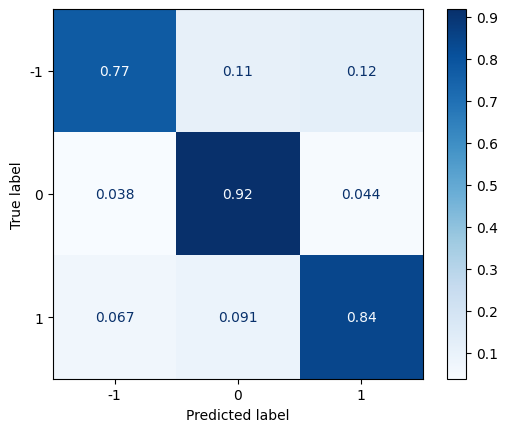

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues", normalize="true")
plt.show()

######Prediction Function

In [34]:
label_map = {-1:"Negative", 0:"Neutral", 1:"Positive"}

In [35]:
def predict_sentiment(text):
    clean = preprocess_text(text, stem=True)
    prep = vectorizer.transform([clean])
    pred = log_reg.predict(prep)[0]
    return label_map[int(pred)]

In [36]:
print(predict_sentiment("I love you"))
print(predict_sentiment("I hate you"))
print(predict_sentiment("I hear you"))

Positive
Negative
Neutral


######Save Model + Vectorizer

In [38]:
with open("LogReg_Sentiment_Model.pkl", "wb") as f:
    pickle.dump(log_reg, f)
with open("Tfidf_Vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)